# Detecting Parkinson’s Disease

<img src="https://dementiatoday.net/wp-content/uploads/2015/07/aging-dementia-122.jpg" width="600"></div>




#### Table of Contents

****Introduction<br>
   Eploring Dataset<br>
   Feature Selection and Scalling<br>
   Baseline Prediction<br>
   Classication<br>
   Hyperparametrs<br>
   Summary****





## Introduction


**What is Parkinson's disease?** <br>
It's a brain disorder affecting mainly elderly people.The disease is caused by impairment or death of neurons in charge of movement.<br>
Main symptoms are stiffness,trembling,bradykinesia(slowed movement),difficulties with balance and coordination,other may include depression,urinary problems or sleep disruptions.<br>
**Difficulties diagnosing**<br>
Currently there's no laboratory tests to detect PD,witch have similliar sympotms to many other diseases making it hard to detect.

**About dataset** <br>
The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. <br>
It contains 195 biomedical voice measurements from 32 people of witch 23 was affected by PD.<br>
The measurments are:<br>
name - ASCII subject name and recording number<br>
MDVP:Fo(Hz) - Average vocal fundamental frequency<br>
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency<br>
MDVP:Flo(Hz) - Minimum vocal fundamental frequency<br>
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
measures of variation in fundamental frequency<br>
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude<br>
NHR,HNR - Two measures of ratio of noise to tonal components in the voice<br>
status - Health status of the subject (one) - Parkinson's, (zero) - healthy<br>
RPDE,D2 - Two nonlinear dynamical complexity measures<br>
DFA - Signal fractal scaling exponent
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3051371/" target="_blank"> Orginal study</a>.
 from 2008 published the feature extraction methods for general voice disorders,and
get 91.4% accuracy using SVM to discriminating healthy people from affected by PD.

**Goal**<br>
Goal of this project is to select best algorithm to help diagnose PD base on voice disorders.<br>
Modeling will be performed using diffrent kinds Sklearn algorithms,and newer ensamble learing libraries.


**Credits**<br>
Citations:

Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 
'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', 
IEEE Transactions on Biomedical Engineering (to appear).

'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)<br>

Links:

<a href="https://www.nia.nih.gov/health/parkinsons-disease/" target="_blank"> PD informations</a>. <br>
<a href="https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/" target="_blank">Dataset Source  </a>.<br>
<a href="https://dementiatoday.net/drug-discovery-for-parkinsons-disease/" target="_blank">Image Source  </a>.<br>




In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns; sns.set()
sns.set_style("darkgrid")
#Machine learining
#For baseline predictions
from sklearn.dummy import DummyClassifier 
#For feature proccesing and model validation,etc
from sklearn.preprocessing import QuantileTransformer,RobustScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,auc,classification_report
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.model_selection import learning_curve,StratifiedKFold,RandomizedSearchCV
from sklearn.feature_selection import RFECV
#Clasification models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
#Bagging/Boosting
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
#Saving model
import joblib
import warnings
warnings.filterwarnings('ignore')

## Exploring dataset

In [2]:
#Reading data
df=pd.read_csv('parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
#Shape of the dataset
df.shape

(195, 24)

In [4]:
#Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

There's no NaN's or missing values. The dataset it's fairly clean and ready to explore.But first let's drop name column since we won't be using it anyway

In [5]:
#Dropping name
df=df.drop(['name'],axis=1)

How does the distribution in data looks?

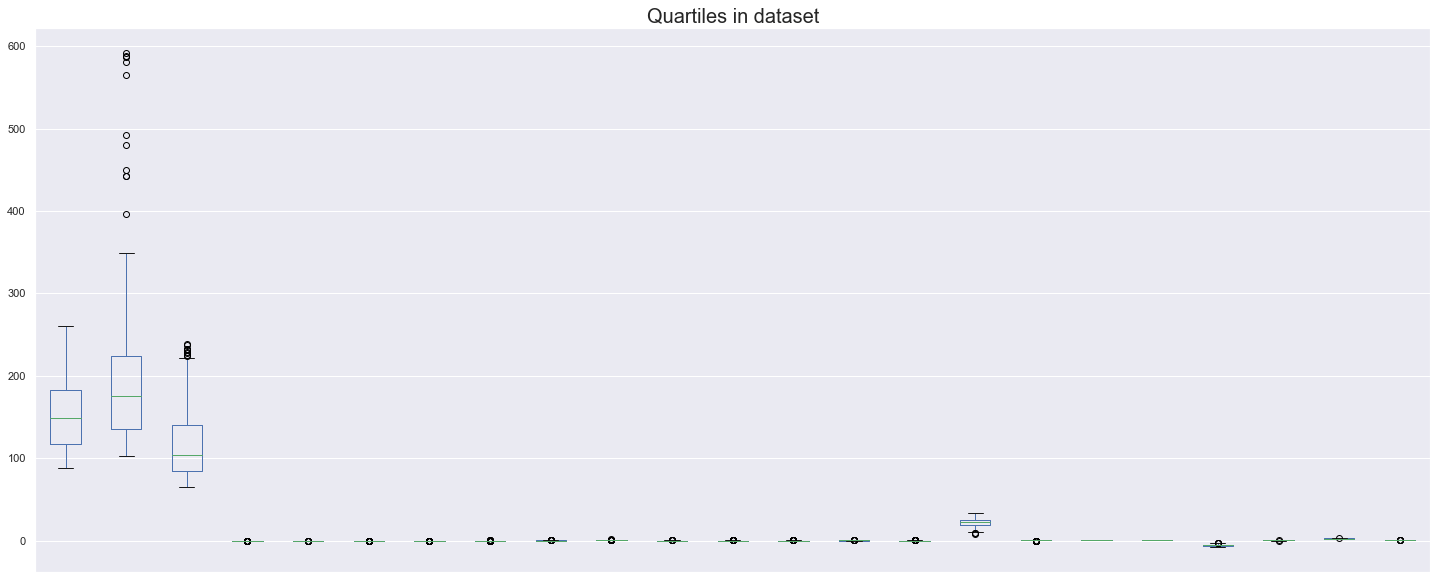

In [6]:
#Plotting distribution 
df.plot.box(figsize=(25,10))
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Quartiles in dataset',fontsize=20);

To get better gasp we can check its skewness and kurtosis 

In [7]:
print('Skewness: \n',df.skew(),'\n','Kurtosis: \n',df.kurt())

Skewness: 
 MDVP:Fo(Hz)         0.591737
MDVP:Fhi(Hz)        2.542146
MDVP:Flo(Hz)        1.217350
MDVP:Jitter(%)      3.084946
MDVP:Jitter(Abs)    2.649071
MDVP:RAP            3.360708
MDVP:PPQ            3.073892
Jitter:DDP          3.362058
MDVP:Shimmer        1.666480
MDVP:Shimmer(dB)    1.999389
Shimmer:APQ3        1.580576
Shimmer:APQ5        1.798697
MDVP:APQ            2.618047
Shimmer:DDA         1.580618
NHR                 4.220709
HNR                -0.514317
status             -1.187727
RPDE               -0.143402
DFA                -0.033214
spread1             0.432139
spread2             0.144430
D2                  0.430384
PPE                 0.797491
dtype: float64 
 Kurtosis: 
 MDVP:Fo(Hz)         -0.627898
MDVP:Fhi(Hz)         7.627241
MDVP:Flo(Hz)         0.654615
MDVP:Jitter(%)      12.030939
MDVP:Jitter(Abs)    10.869043
MDVP:RAP            14.213798
MDVP:PPQ            11.963922
Jitter:DDP          14.224762
MDVP:Shimmer         3.238308
MDVP:Shimmer(dB)     5

The data is unbalanced,and suffers from presence of outliers. <br>
In order to select best features and prevent classifiction for overfitting, i chose correlation as selcting tool.

## Feature Selection and Scalling

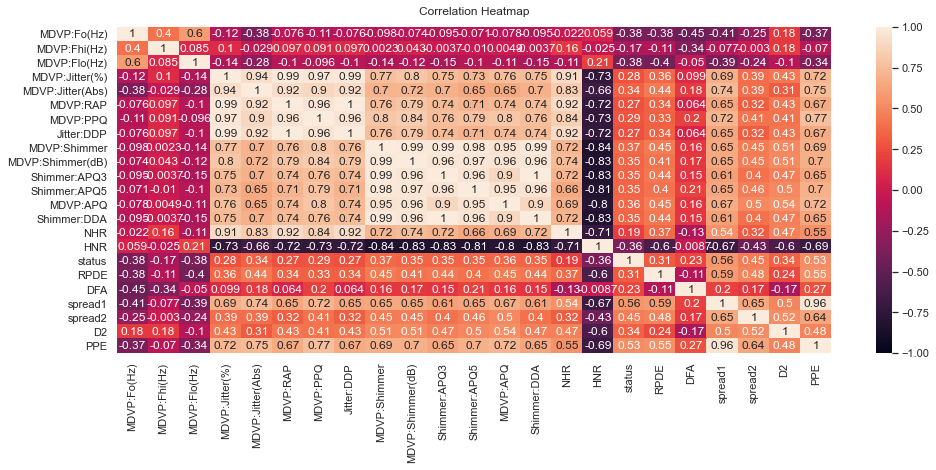

In [8]:
#Plotting Correlation matrix
plt.figure(figsize=(16, 6))
heatmap=sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

For more clarity let's get absolute correlation beetwen status and other columns

In [9]:
#Absolute corelation beetwen status and other columns
df.corr()['status'].abs().sort_values(ascending=False)

status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Fo(Hz)         0.383535
MDVP:Flo(Hz)        0.380200
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
HNR                 0.361515
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
MDVP:Jitter(Abs)    0.338653
RPDE                0.308567
MDVP:PPQ            0.288698
MDVP:Jitter(%)      0.278220
MDVP:RAP            0.266668
Jitter:DDP          0.266646
DFA                 0.231739
NHR                 0.189429
MDVP:Fhi(Hz)        0.166136
Name: status, dtype: float64

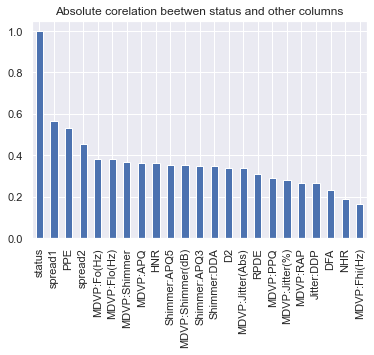

In [10]:
#Plotting absolute corelation beetwen status and other columns
df.corr()['status'].abs().sort_values(ascending=False).plot.bar()
plt.title('Absolute corelation beetwen status and other columns');

Columns MDVP:Fhi(Hz),NHR and DFA have the weakest correlation (>0,25),so let's drop them.

In [11]:
#Dropping columns
df=df.drop(columns=['MDVP:Fhi(Hz)', 'NHR','DFA'])

Now we can split the dataframe 

In [12]:
#Getting features and labels
features=df.loc[:,df.columns!='status'].values
labels=df.loc[:,'status'].values

How many of measurements was positive/negative?

In [13]:
#Calculating number of positive and negative measurements
print('Number of positive measurements:',labels[labels==1].shape[0]
      ,'\nNumber of negative measurements:',labels[labels==0].shape[0])

Number of positive measurements: 147 
Number of negative measurements: 48


For sanity check of feature selection simplifed plot will be of use

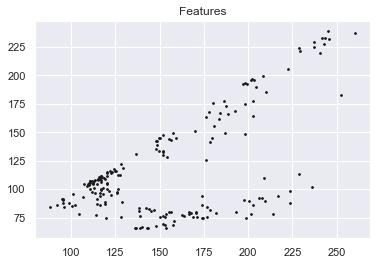

In [14]:
#Plotting features
plt.scatter(features[:, 0], features[:, 1], color='k',s=3)
plt.title('Features');

Next step is visualsing the outliers with Local Outlier Factor

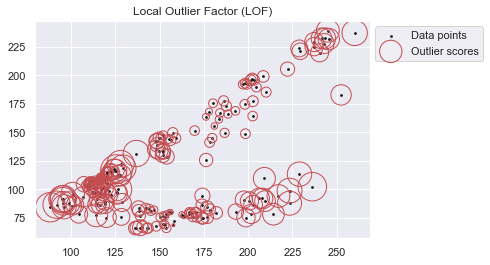

In [15]:
#Fining outliers
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(features)
X_scores = lof.negative_outlier_factor_

#Plotting results
plt.title("Local Outlier Factor (LOF)")
plt.scatter(features[:, 0], features[:, 1], color='k', s=3., label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(features[:, 0], features[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Finally the Distribiution curve 

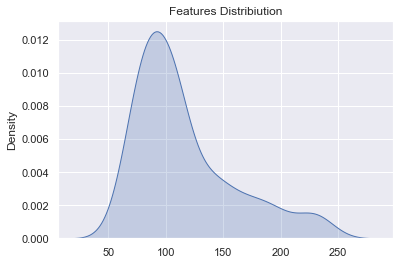

In [16]:
sns.kdeplot(features[:, 1],shade=True)
plt.title("Features Distribiution");

Given the data range,distribition and outliers i decided to use scaler taking account of interquartile range.<br>

In [17]:
#Scaling
scaler=RobustScaler()
X=scaler.fit_transform(features)
y=labels

And how does scaled data look?

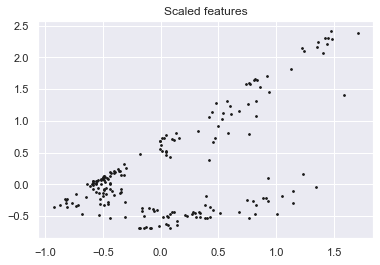

In [18]:
#Plotting scaled features
plt.scatter(X[:, 0], X[:, 1], color='k',s=3)
plt.title('Scaled features');

At last,let's split data into training and testing set

In [19]:
#Splitting the data
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=7)

In [20]:
#Shape of splited data
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)

X_train shape:  (156, 19)
y_train shape:  (156,)


## Baseline predictions

In [21]:
#Making baseline predictions
strategies=['stratified', 'most_frequent', 'prior', 'uniform']
test_scores=[] 
name=[]
for strategy in strategies:
    dclf= DummyClassifier(strategy=strategy)
    dclf.fit(X_train, y_train) 
    score = dclf.score(X_test, y_test) 
    test_scores.append(score) 
print("\n".join("{} {}".format(x, y) for x, y in zip(strategies, test_scores)))

stratified 0.5128205128205128
most_frequent 0.8205128205128205
prior 0.8205128205128205
uniform 0.46153846153846156


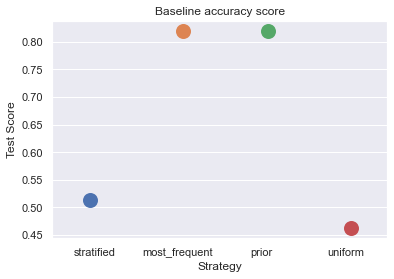

In [22]:
#Plotting baseline predictions
ax = sns.stripplot(x=strategies,y=test_scores,size=15); 
ax.set(xlabel ='Strategy', ylabel ='Test Score',title="Baseline accuracy score");

Dummy classifier did well to predict labels,so we are on good way with both features and scalling

## Classification
Models witch we'll evaluating are:<br>
**From Sklearn:**<br>
**Machine learing:**<br>
Logistic Regression<br>
K Nearest Neighbors<br>
Support Vector Classification with rbf,poly and sigmoid kernels<br>
Gaussian Naive Bayes<br>
Decision Tree<br>
Stochastic Gradient Descent<br>
**Neural Networks:**<br>
Multi-layer Perceptron <br>
**Ensamble learing:**<br>
AdaBoost<br>
Gradient Boosting<br>
Random Forest<br>
Extra Trees<br>
**Non-sklearn Ensamble Algorithms:**<br>
XGB<br>
Catboost<br>
LightGBM<br>

Becouse Sklearn Ensamble learing are really sensitive for outliers,modeling with them will require rescalling the samples.<br>
Considering this and baseline,witch performed poorly with uniform classication best scaler seems to be
Quantile Transformer with normal distribiution.<br>
It's also wrorth mentioning that K Nearest Neighbors will perform better with less distance between data points.<br>
At this point the only metrics i'll be using are: Accuracy score,Accuracy with 10-fold cross validation and AUC score.

In [23]:
#Defining fold for cross validation
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=0)

In [24]:
#Classification models
clf = []
clf.append(('LG',LogisticRegression()))
clf.append(('SGD',SGDClassifier()))
clf.append(('KNN',KNeighborsClassifier()))
clf.append(('SVC',SVC()) )
clf.append(('SVC_s',SVC(kernel = 'sigmoid')))
clf.append(('SVC_p',SVC(kernel = 'poly')))
clf.append(('NB',GaussianNB()))
clf.append(('DT',(DecisionTreeClassifier())))
clf.append(('MLP',MLPClassifier()))
clf.append(('XGB',XGBClassifier()))
clf.append(('LGBM',LGBMClassifier()))
clf.append(('CB',CatBoostClassifier(logging_level = 'Silent')))

In [25]:
#Evaluation and validation of models

results=[]
names=[]
for name, model in clf:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies = cross_val_score(model, X_train, y_train, cv = fold)
    results.append(accuracies)
    names.append(name)
    print(name)  
    print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('Accuracy (10-fold cross validation): {:.2f}'.format(accuracies.mean()*100))
    print('AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred)))


LG
Accuracy score: 0.8718
Accuracy (10-fold cross validation): 84.71
AUC score: 0.6987
SGD
Accuracy score: 0.8718
Accuracy (10-fold cross validation): 86.54
AUC score: 0.7545
KNN
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 84.67
AUC score: 0.7857
SVC
Accuracy score: 0.8718
Accuracy (10-fold cross validation): 85.38
AUC score: 0.6429
SVC_s
Accuracy score: 0.8462
Accuracy (10-fold cross validation): 82.75
AUC score: 0.6830
SVC_p
Accuracy score: 0.8462
Accuracy (10-fold cross validation): 85.38
AUC score: 0.5714
NB
Accuracy score: 0.7436
Accuracy (10-fold cross validation): 71.25
AUC score: 0.7321
DT
Accuracy score: 0.8718
Accuracy (10-fold cross validation): 78.92
AUC score: 0.8103
MLP
Accuracy score: 0.9487
Accuracy (10-fold cross validation): 86.58
AUC score: 0.8571
XGB
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 89.62
AUC score: 0.8415
LGBM
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 89.04
AUC score: 0.8415
CB
Accuracy score: 0.9231
Accu

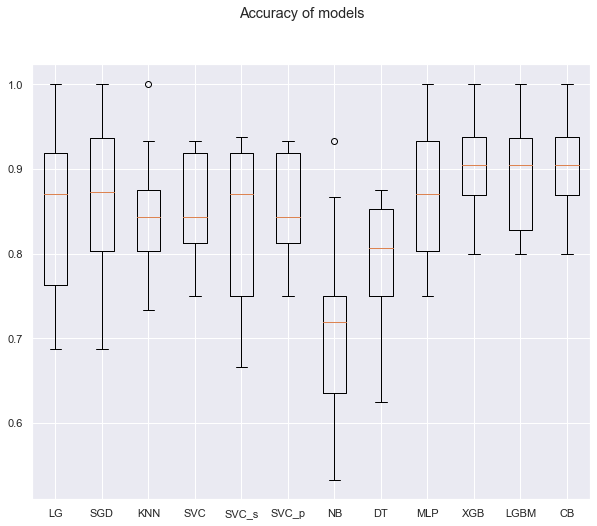

In [26]:
#Plotting accuracy
fig = plt.figure(figsize=(10,8))
fig.suptitle('Accuracy of models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names);

The best models was CatBoost and XGB.<br>
And we can check Boosting and Bagging algorithms,as well as KNN with differently scaled data.

In [27]:
#Models
pp=[]

pp.append(('KNN',Pipeline([('scale',QuantileTransformer(output_distribution='normal')),('KNN',KNeighborsClassifier())])))
pp.append(('AB',Pipeline([('scale',QuantileTransformer(output_distribution='normal')),('AB',AdaBoostClassifier())])))
pp.append(('GB',Pipeline([('scale',QuantileTransformer(output_distribution='normal')),('GB',GradientBoostingClassifier())])))
pp.append(('RF',Pipeline([('scale',QuantileTransformer(output_distribution='normal')),('rf',RandomForestClassifier())])))
pp.append(('ECT',Pipeline([('scale',QuantileTransformer(output_distribution='normal')),('ETC',ExtraTreesClassifier())])))

In [28]:
#Results
names=[]
results=[]

for name, model in pp:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies = cross_val_score(model, X_train, y_train, cv = fold)
    names.append(name)
    results.append(accuracies)

    print(name)  
    print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('Accuracy (10-fold cross validation): {:.2f}'.format(accuracies.mean()*100))
    print('AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred)))


KNN
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 90.46
AUC score: 0.7857
AB
Accuracy score: 0.8974
Accuracy (10-fold cross validation): 89.08
AUC score: 0.8259
GB
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 88.38
AUC score: 0.8415
RF
Accuracy score: 0.8974
Accuracy (10-fold cross validation): 86.58
AUC score: 0.7701
ECT
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 87.29
AUC score: 0.7857


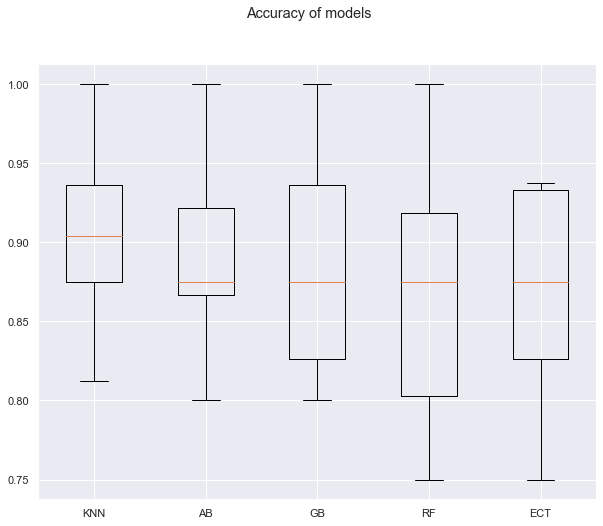

In [29]:
#Plotting accuracy
fig = plt.figure(figsize=(10,8))
fig.suptitle('Accuracy of models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names);

Now we definitlly know that Catboost,and alternatively scaled KNN are best models.<br>
In next step,we'll try to improve them with hyperparameters

## Hyperparameters
Searching for best parametrs to tune KNN and will be done comparing GridSearchCV and RandomizedSearchCV results.<br>
As for validation, using more metrics this time will be helpful.

In [30]:
#RandomizedSearchCV for CB
#Params 
params = {'iterations': [500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]}

#Search
randm = RandomizedSearchCV(CatBoostClassifier(), params,
                               cv =fold,n_iter=10,random_state=5, n_jobs=-1,refit=True)
grid=randm.fit(X_train, y_train)
grid.best_params_

{'random_seed': 42,
 'loss_function': 'Logloss',
 'logging_level': 'Silent',
 'leaf_estimation_iterations': 10,
 'l2_leaf_reg': 1e-19,
 'iterations': 500,
 'depth': 5}

In [31]:
#GridSearchCV for CB
clf_grid = GridSearchCV(CatBoostClassifier(), params, cv = fold,refit=True)
grid=clf_grid.fit(X_train, y_train)
grid.best_params_

{'depth': 5,
 'iterations': 500,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 42}

In [32]:
#GridSearchCV for KNN
#Params
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
metrics=['minkowski','euclidean','manhattan'] 
weights=['uniform','distance'] 
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p,metric=metrics,weights=weights)
#Search
knn = make_pipeline(QuantileTransformer(output_distribution='normal'), 
                    GridSearchCV(KNeighborsClassifier(),
                                 hyperparameters,cv=fold,refit=True))

model=knn.fit(X_train,y_train)

model[1].best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                     weights='uniform')

In [33]:
#RandomizedSearchCV for KNN
rand = make_pipeline(QuantileTransformer(output_distribution='normal'), 
                    RandomizedSearchCV(KNeighborsClassifier(),
                                 hyperparameters, n_iter=10,random_state=5,cv=fold,refit=True))
model=rand.fit(X_train,y_train)

model[1].best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [34]:
#Best models
CB_rs=CatBoostClassifier( l2_leaf_reg= 1e-19,
 depth=5,
 loss_function= 'Logloss',
 logging_level= 'Silent',
 leaf_estimation_iterations= 10)


CB_gs=CatBoostClassifier(l2_leaf_reg= 1e-20,
 depth= 5,                        
 leaf_estimation_iterations= 10,
 logging_level= 'Silent',
 loss_function= 'Logloss',)

KNN_gs=Pipeline([('scale',QuantileTransformer(output_distribution='normal')),
                       ('KNN',KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=1,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None,
                                                   n_neighbors=6, 
                                                   p=1,weights='uniform'))])


KNN_rs=Pipeline([('scale',QuantileTransformer(output_distribution='normal')),
                       ('KNN',KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=6,
                                                   metric='manhattan',
                                                   metric_params=None,
                                                   n_jobs=None,
                                                   n_neighbors=3,
                                                   p=2,weights='uniform'))])

In [35]:
#Validating best models 
best=[]
best.append(('KNN_rs',KNN_rs))
best.append(('KNN_gs',KNN_gs))
best.append(('CB_rs',CB_rs))
best.append(('CB_gs',CB_gs))

target_names = ['Healthy','Diseased']
names=[]
    
for name, model in best:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies = cross_val_score(model, X_train, y_train, cv = fold)
    names.append(name)
    cm = confusion_matrix(y_test, y_pred)
    spec = cm[0,0]/(cm[0,0]+cm[0,1])
    sens = cm[1,1]/(cm[1,0]+cm[1,1])
    prec = cm[1,1]/(cm[0,1]+cm[1,1])

    print(name)  
    print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('Accuracy (10-fold cross validation): {:.2f}'.format(accuracies.mean()*100))
    print('Standard deviation accuracy (10-fold cross validation): {:.2f}'.format(accuracies.std()*100))
    print('AUC score: {:.4f}'.format(roc_auc_score(y_test, y_pred)))
    print('Confusion Matrix: {}'.format(cm))
    print('Sensitivity: {:.2f} \nSpecificity: {:.2f} \nPrecision: {:.2f}'.format(sens, spec, prec))
    print(classification_report(y_test, y_pred, target_names=target_names))

KNN_rs
Accuracy score: 0.9231
Accuracy (10-fold cross validation): 90.42
Standard deviation accuracy (10-fold cross validation): 7.66
AUC score: 0.8973
Confusion Matrix: [[ 6  1]
 [ 2 30]]
Sensitivity: 0.94 
Specificity: 0.86 
Precision: 0.97
              precision    recall  f1-score   support

     Healthy       0.75      0.86      0.80         7
    Diseased       0.97      0.94      0.95        32

    accuracy                           0.92        39
   macro avg       0.86      0.90      0.88        39
weighted avg       0.93      0.92      0.93        39

KNN_gs
Accuracy score: 0.9744
Accuracy (10-fold cross validation): 89.17
Standard deviation accuracy (10-fold cross validation): 6.82
AUC score: 0.9286
Confusion Matrix: [[ 6  1]
 [ 0 32]]
Sensitivity: 1.00 
Specificity: 0.86 
Precision: 0.97
              precision    recall  f1-score   support

     Healthy       1.00      0.86      0.92         7
    Diseased       0.97      1.00      0.98        32

    accuracy           

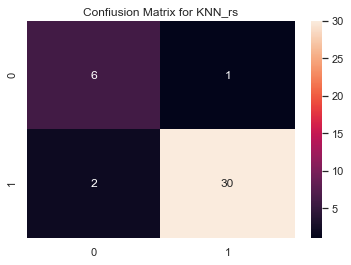

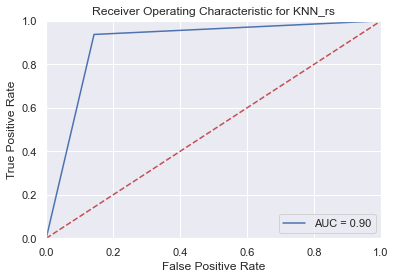

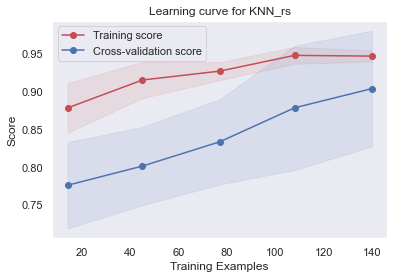

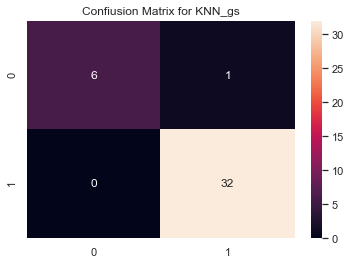

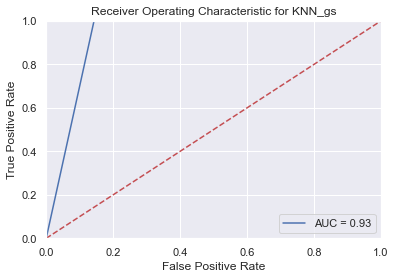

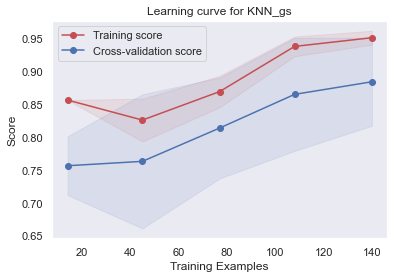

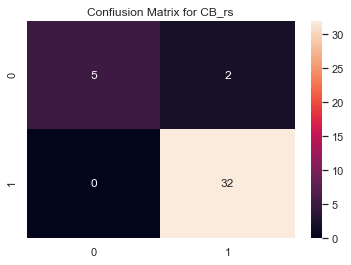

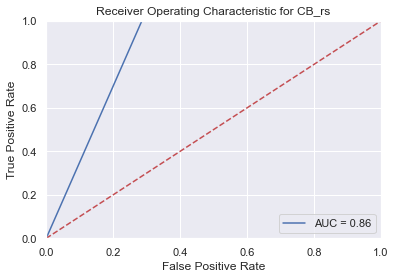

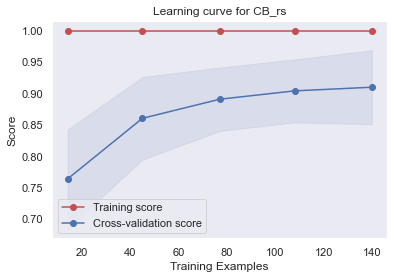

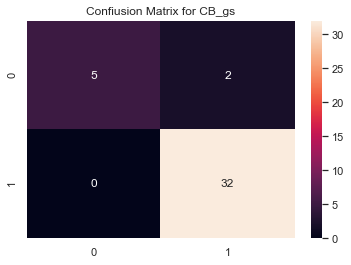

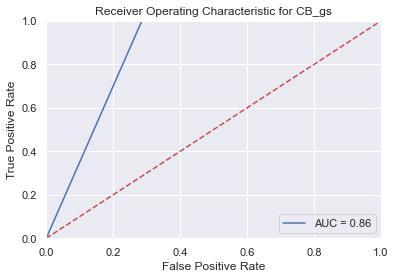

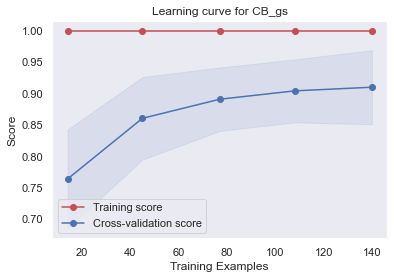

In [36]:
#Plotting the results
for name, model in best:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    names.append(name)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=fold)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    
    sns.heatmap(cm, annot=True)
    plt.title('Confiusion Matrix for '+name)

    plt.show()
    plt.title('Receiver Operating Characteristic for '+name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
    
    plt.title('Learning curve for '+name)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    
    


It's hard to choose best model from the above.
Both serching methods have given us nice results.KNN surprisingly seems to be the best model,although the random gridsearch CV based one get better results in both accuracy and its standard deviation,it and also happend to have best AUC and identify more people with PD.<br>
Catboost's are really similar to each other,but that's probably becouse of small number of features to evaluate.Despite worse accuracy in comparison to KNN it was fairly good interms of identifing the diseased.<br>
Saddly KNN doesn't have any way to get importance of features,so this time we can't explore them.

## Summary
The data set was strongly unbalanced,and in order to make better predictions i decided to choose features base on correlation.MDVP:Fhi(Hz),NHR and DFA seemed to have the weakest correlation,and so i don't include them.Another way to do this(and maybe get better results) is F-Score.Then i apply Robust Scaler,to scale the features with resepct to their IQR.For few models i rescale the data with Quantile Transformer with normal distribution. The best models were KNeighbors and Catboost.Search for better parameters was done with Sklearn methods,but Hyperopt,Skopt or Optuna could give better results,especially for CB.<br>
In the end KNeighborsClassifier with applied alternative scaling and parameters: algorithm='auto', leaf_size=1,metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=1,weights='uniform')was the best model scoring acuraccy = 0.9744 and auc = 0.9286.

In [37]:
#saveing model
joblib.dump(KNN_gs,'KNN.pkl');